# Exploration and forecasting of Air Quality in Madrid.

## Introduction

With the given dataset, the objective of this notebook is to predict the evolution of the Air Quality in Madrid. To do so, an Exploration will be performed. After that, a preparation of data will be done to train FBProphet model on it. The result will be evaluated and a trend will be extracted. So first let's load data

## Loading data

We have 1 dataset of Stations and 17 dataset for datas from 2001 to 2018. All datasets don't have the same datas so we will still merge them but let's also take a look at what we have :

In [1]:
import os
import sys
import math

import time

import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import folium
from folium import plugins

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

%matplotlib inline

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
stations = pd.read_csv('input/stations.csv')

present = defaultdict(list)
dfs = []
for year in range(2001, 2018):
    df = pd.read_csv('input/csvs_per_year/madrid_{}.csv'.format(year))
    for col in df:
        present[col].append(year)
    dfs.append(df)
df = pd.concat(dfs)

df.date = pd.to_datetime(df.date)

del dfs

In [3]:
df.head()

,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL,date,station
0,NaN,NaN,0.37,NaN,NaN,NaN,NaN,58.400002,87.150002,NaN,34.529999,105.000000,NaN,NaN,6.34,NaN,NaN,2001-08-01 01:00:00,28079001
1,1.5,NaN,0.34,1.49,4.1,0.07,NaN,56.250000,75.169998,2.11,42.160000,100.599998,NaN,1.73,8.11,1.24,10.82,2001-08-01 01:00:00,28079035
2,NaN,NaN,0.28,NaN,NaN,NaN,NaN,50.660000,61.380001,NaN,46.310001,100.099998,NaN,NaN,7.85,NaN,NaN,2001-08-01 01:00:00,28079003
3,NaN,NaN,0.47,NaN,NaN,NaN,NaN,69.790001,73.449997,NaN,40.650002,69.779999,NaN,NaN,6.46,NaN,NaN,2001-08-01 01:00:00,28079004
4,NaN,NaN,0.39,NaN,NaN,NaN,NaN,22.830000,24.799999,NaN,66.309998,75.180000,NaN,NaN,8.80,NaN,NaN,2001-08-01 01:00:00,28079039


In [4]:
stations.head()

,id,name,address,lon,lat,elevation
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
1,28079008,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,670
2,28079011,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,708
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693
4,28079017,Villaverde,C/. Juan Peñalver,-3.713322,40.347139,604


In [5]:
width = len(present.keys())-2
height = len(present["date"])

p = np.zeros(shape = (height, width), dtype = np.float32)
i = 0
x_ticks = []
y_ticks = list(range(2001, 2018))
for col in present.keys():
    if col in ["date", "station"] : continue
    
    x_ticks.append(col)
    for year in present[col]:
        p[year-2001, i] = df[df.date.dt.year == year][col].notnull().mean()
    i+=1

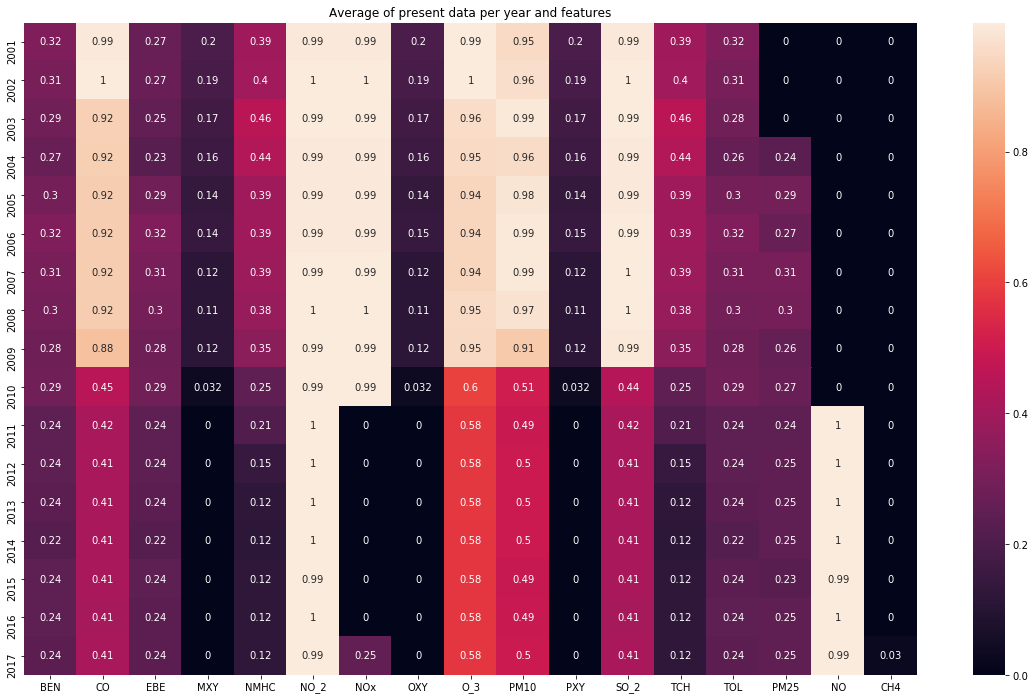

In [6]:
t = pd.DataFrame(p, columns = x_ticks, index=y_ticks)

plt.figure(figsize=(20,12))
sns.heatmap(t, annot=True)
plt.title("Average of present data per year and features")
plt.show()

# Geographic data

For the given stations, we can see on the plot below that they are on multiple places. As we will do a mean after, the objectif is to "reduce" the area covered by all station to a smaller area. To do so, we will just keep the stations in a radius of 7.5 km around the center of the city (placed at Puerta del Sol). The dataset will be filtered to keep only datas on those area.

In [7]:
center = [40.41694727138085, -3.7035298347473145]

def get_dist(lon_a,lat_a, lon_b, lat_b):
    x = (lon_b - lon_a)*math.cos( (lat_a+lat_b)/2 )
    y = lat_b - lat_a
    d = 6371 * math.sqrt( x**2 + y**2 )
    return d

kept_id = []
center_lat = math.radians(center[0])
center_lon = math.radians(center[1])
for i in range(len(stations)):
    lon = math.radians(stations.loc[i, "lon"])
    lat = math.radians(stations.loc[i, "lat"])

    distance = get_dist(lon, lat, center_lon, center_lat)
    if distance < 7.5:
        kept_id.append(stations.loc[i, "id"])
df = df[df["station"].isin(kept_id)]

In [8]:
city = folium.Map(location=center, zoom_start=15)

folium.Marker(location=center, icon=folium.Icon(color='blue'), popup='Center').add_to(city)

folium.Circle(location=center, radius=7500,
                        popup='Considered Area', #line_color='#3186cc',
                        fill_color='#3186cc').add_to(city)

for i in range(len(stations)):
    lon = stations.loc[i, "lon"]
    lat = stations.loc[i, "lat"]
    name = stations.loc[i, "name"]
    color = "green" if stations.loc[i, "id"] in kept_id else "red"
    folium.Marker(location=[lat, lon], icon=folium.Icon(color=color), popup=name).add_to(city)
    
city

Now let's merge data per date and keep the average of every features. After that, I keep all features with more than 99.9 % of non-missing data. to finish, all rows with missing datas are removed (~300 rows on 149000)

In [9]:
df_grouped = df.groupby(["date"]).mean()
df_grouped.drop("station", axis=1, inplace = True)

In [10]:
to_delete = []
for col in df_grouped:
    if df_grouped[col].isnull().mean() > 0.001:
        to_delete.append(col)
df_grouped.drop(to_delete, axis=1, inplace = True)

df_grouped = df_grouped.dropna()

In [11]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148833 entries, 2001-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 8 columns):
BEN     148833 non-null float64
CO      148833 non-null float64
EBE     148833 non-null float64
NO_2    148833 non-null float64
O_3     148833 non-null float64
PM10    148833 non-null float64
SO_2    148833 non-null float64
TOL     148833 non-null float64
dtypes: float64(8)
memory usage: 10.2 MB


In [12]:
df_grouped.head()

,BEN,CO,EBE,NO_2,O_3,PM10,SO_2,TOL
date,,,,,,,,
2001-01-01 01:00:00,2.340000,1.179091,2.085,56.646365,6.458182,34.118999,19.038182,9.216667
2001-01-01 02:00:00,4.240000,1.897273,3.565,56.976364,5.937273,40.768750,20.550909,13.296667
2001-01-01 03:00:00,5.100000,2.168182,4.345,56.643636,5.633636,60.435000,22.309091,17.100000
2001-01-01 04:00:00,6.473333,1.960000,5.880,58.456364,5.986364,49.323000,21.109091,23.850000
2001-01-01 05:00:00,5.113334,1.399091,4.800,54.026363,6.779091,38.812000,17.809091,20.466667


# Model

Now we have a dataset prepared for the model. For the model we have multiple options :

- We sum all features (easy but we sum features of differents scale and type - to me, it's not good but it's used on another Kernel)
- We use a Standard Scaler on every features and sum it (this is better because we are not anymore biaised by the scale but we still sum apples and oranges
- We run 1 model per features (slower and with more noise)

So let's try the 2nd and 3rd option

## 2nd Option : Only on "CO"

### Split train/test

In [13]:
final_df = df_grouped.reset_index()[["date", "CO"]]
final_df.columns = ["ds", "y"]

In [14]:
final_df.head()

,ds,y
0,2001-01-01 01:00:00,1.179091
1,2001-01-01 02:00:00,1.897273
2,2001-01-01 03:00:00,2.168182
3,2001-01-01 04:00:00,1.960000
4,2001-01-01 05:00:00,1.399091


The Train Set will be the year 2001 to 2016 and the rest will be test set

In [15]:
df_train = final_df[final_df["ds"].dt.year < 2016]
df_test = final_df[final_df["ds"].dt.year >= 2016]

In [16]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131290 entries, 0 to 131289
Data columns (total 2 columns):
ds    131290 non-null datetime64[ns]
y     131290 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17543 entries, 131290 to 148832
Data columns (total 2 columns):
ds    17543 non-null datetime64[ns]
y     17543 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 411.2 KB
None


In [17]:
print(df_test.head())
print(df_test.tail())

                        ds         y
131290 2016-01-01 00:00:00  0.377778
131291 2016-01-01 01:00:00  0.455556
131292 2016-01-01 02:00:00  0.511111
131293 2016-01-01 03:00:00  0.488889
131294 2016-01-01 04:00:00  0.422222
                        ds         y
148828 2017-12-31 20:00:00  0.311111
148829 2017-12-31 21:00:00  0.333333
148830 2017-12-31 22:00:00  0.288889
148831 2017-12-31 23:00:00  0.255556
148832 2018-01-01 00:00:00  0.233333


### Fitting the model

In [18]:
model = Prophet(changepoint_prior_scale=2.5, daily_seasonality=True)

start = time.time()
model.fit(df_train)
print("Fitting duration : {:.3f}s".format(time.time() - start) )

C:\python36\envs\machine_learning\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Fitting duration : 310.511s


In [19]:
future_data = df_test.drop("y", axis=1)

start = time.time()
forecast_data = model.predict(future_data)
print("Predict duration : {:.3f}s".format(time.time() - start) )

forecast_data["y"] = df_test["y"].values
forecast_data[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Predict duration : 24.465s


,ds,y,yhat,yhat_lower,yhat_upper
17538,2017-12-31 20:00:00,0.311111,0.680548,-0.949987,2.294276
17539,2017-12-31 21:00:00,0.333333,0.773006,-0.921390,2.328024
17540,2017-12-31 22:00:00,0.288889,0.803439,-0.857322,2.469653
17541,2017-12-31 23:00:00,0.255556,0.765295,-0.880830,2.352130
17542,2018-01-01 00:00:00,0.233333,0.692313,-0.983232,2.316762


Now let's compare the prediction and confidence to the real data (you can zoom, pan on the plot)

In [20]:
py.iplot([
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='y'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat'], name='yhat'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['trend'], name='Trend')
])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Metric

For the metric, I'll compute the MSE for every 2 days (48 hours of data) to check how it evolves during the complete year

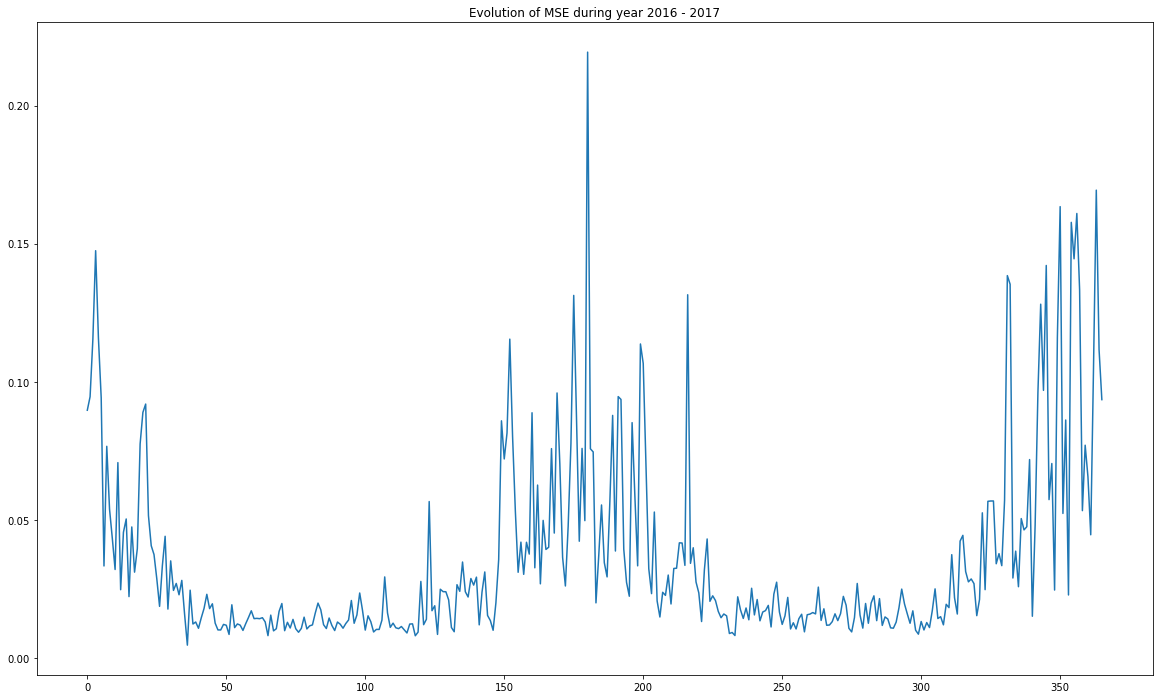

In [21]:
mse = []
for i in range(0, len(forecast_data), 48):
    mse.append(mean_squared_error(
                    forecast_data.loc[i:i+48, "y"],
                    forecast_data.loc[i:i+48, "yhat"]
                ))

plt.figure(figsize=(20,12))
plt.plot(mse) # mse per day during 2 years
plt.title("Evolution of MSE during year 2016 - 2017")
plt.show()

We can see that we have a correct MSE during the summer but every winter have a lot more error. This can be explained with weather. We have peaks of error which may be explained by the lack of wind. This is more difficult to predict. As a result, the pollution generated by heating system stacked over the city and decrease quickly when wind is back. The rest of the time we have a quite good approximation

To finish, we have a good feature in FBProphet too which is the visualisation of temporal variations. Let's check it :

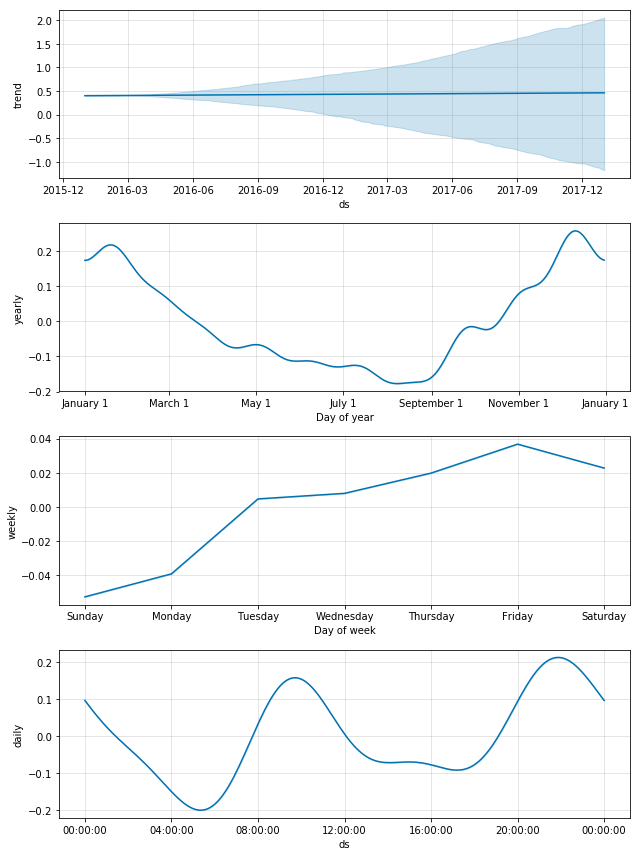

In [22]:
model.plot_components(forecast_data)
plt.show()

We have now 4 analysis. 
- A global trend which is stable but provide uncertaincy. This is logical as we predict over 2 years of data. We can't be sure about a prediction at long terme as there is a lot of factors.
- A yearly trend which highlight the pollution created mainly by heating systems.
- A weekly trend which is mainly the effect of industry. We can see that it rises during weekdays with a slight delay of around 1 day (time to pollute the air)
- A daily trend chich highlight the pollution created mainly by cars. We can see 2 peaks in the morning and in late afternoon/ start of night. 

> # 3rd Option : Sum of Scaled Features

Now let's do the same but with all features scaled (using Standard Scaler) and sum together. Before to continue, We won't be able to compare both score as they are on differents scale !

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
df_train2 = df_grouped[ df_grouped.index.year < 2016 ]
df_test2 = df_grouped[ df_grouped.index.year >= 2016 ]

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train2)
X_test = scaler.transform(df_test2)

df_train2["sum"] = X_train.sum(axis=1)
df_test2["sum"] = X_test.sum(axis=1)

C:\python36\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\python36\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [26]:
df_train2.head()

,BEN,CO,EBE,NO_2,O_3,PM10,SO_2,TOL,sum
date,,,,,,,,,
2001-01-01 01:00:00,2.340000,1.179091,2.085,56.646365,6.458182,34.118999,19.038182,9.216667,4.944103
2001-01-01 02:00:00,4.240000,1.897273,3.565,56.976364,5.937273,40.768750,20.550909,13.296667,10.593003
2001-01-01 03:00:00,5.100000,2.168182,4.345,56.643636,5.633636,60.435000,22.309091,17.100000,14.359622
2001-01-01 04:00:00,6.473333,1.960000,5.880,58.456364,5.986364,49.323000,21.109091,23.850000,16.474488
2001-01-01 05:00:00,5.113334,1.399091,4.800,54.026363,6.779091,38.812000,17.809091,20.466667,11.452645


In [27]:
final_df_train = df_train2.reset_index()[["date", "sum"]]
final_df_train.columns = ["ds", "y"]

final_df_test = df_test2.reset_index()[["date", "sum"]]
final_df_test.columns = ["ds", "y"]

In [28]:
model = Prophet(changepoint_prior_scale=2.5, daily_seasonality=True)

start = time.time()
model.fit(final_df_train)
print("Fitting duration : {:.3f}s".format(time.time() - start) )

C:\python36\envs\machine_learning\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Fitting duration : 493.138s


In [29]:
future_data = final_df_test.drop("y", axis=1)

start = time.time()
forecast_data = model.predict(future_data)
print("Predict duration : {:.3f}s".format(time.time() - start) )

forecast_data["y"] = final_df_test["y"].values
forecast_data[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Predict duration : 23.996s


,ds,y,yhat,yhat_lower,yhat_upper
17538,2017-12-31 20:00:00,-4.900591,0.287083,-20.239388,21.201574
17539,2017-12-31 21:00:00,-4.492468,1.219960,-20.372294,21.894172
17540,2017-12-31 22:00:00,-4.714367,1.570580,-20.437778,22.384803
17541,2017-12-31 23:00:00,-5.039149,1.162781,-20.718190,22.186573
17542,2018-01-01 00:00:00,-5.294764,0.263200,-21.720327,21.068446


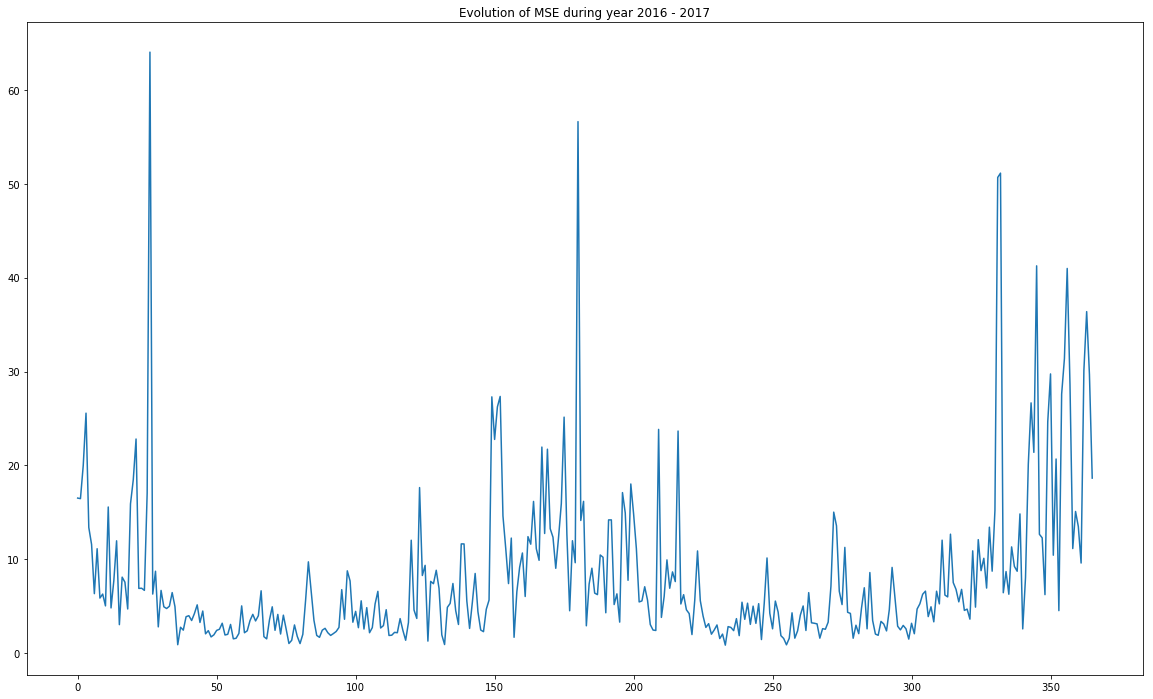

In [30]:
mse = []
for i in range(0, len(forecast_data), 48):
    mse.append(mean_squared_error(
                    forecast_data.loc[i:i+48, "y"],
                    forecast_data.loc[i:i+48, "yhat"]
                ))

plt.figure(figsize=(20,12))
plt.plot(mse) # mse per day during 2 years
plt.title("Evolution of MSE during year 2016 - 2017")
plt.show()

In [31]:
py.iplot([
    go.Scatter(x=df_test['ds'], y=final_df_test['y'], name='y'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat'], name='yhat'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast_data['ds'], y=forecast_data['trend'], name='Trend')
])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


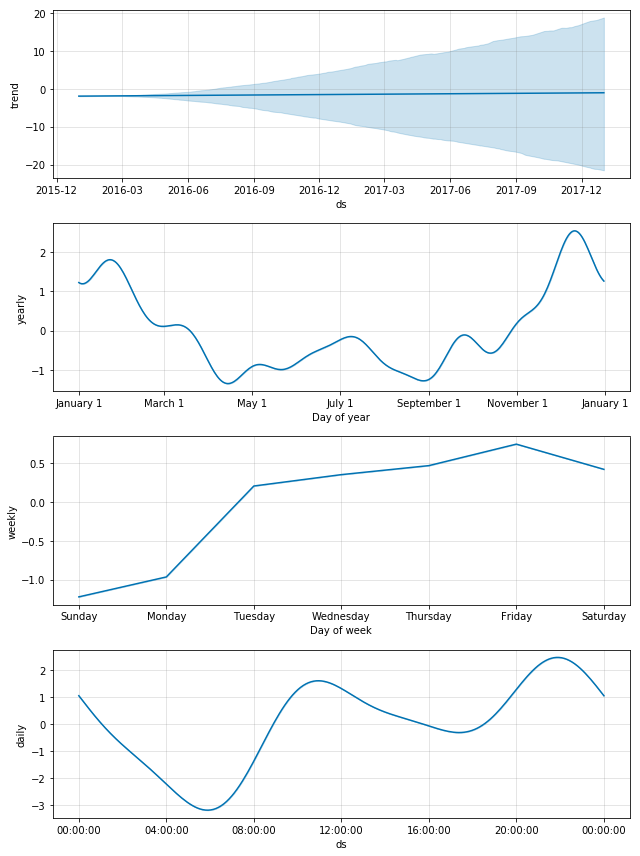

In [32]:
model.plot_components(forecast_data)
plt.show()

We can see that we still have an increase of MSE during winter but the main difference is the daily trend. the yrealy and weekly trends remains similars but the daily hase a lot less dicrease during the day. This means that we produce a lot more of other pollutants during the day and this leads to a more important "bad quality" of air.

# Conclusion

We can conclude that the model FBProphet is not perfect to predict trends for a long terme prediction and may be wrong in some specific case (days without wind ou with too much wind). A dataset of wind may be required to conclude about that but it's more and more often that big citys have a bad quality of air during days without wind aither in summer due to cars but also during winter with heating systems.

Nevertheless, this model is able to highlight seasonality (multiple scales) easily with only the target as input data. 